# Heart Disease Prediction Model Training

This notebook implements:
1. **Binary Classification** (Disease Detection)
2. **Multi-class Classification** (Severity Assessment with grouped classes)
3. **XGBoost Ordinal Classification** (leveraging ordinal nature of severity)
4. **Hierarchical vs Multi-class Comparison** (to determine best approach)
5. **Hyperparameter Tuning** with RandomizedSearchCV
6. **Class Imbalance Handling** (BorderlineSMOTE, class weights)
7. **Comprehensive Evaluation** (F1-score focused)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, accuracy_score
)
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
import pickle
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Load Preprocessed Data

In [2]:
# Load binary classification data
X_train_bin = pd.read_csv('../data/processed/X_train_binary.csv')
X_test_bin = pd.read_csv('../data/processed/X_test_binary.csv')
y_train_bin = pd.read_csv('../data/processed/y_train_binary.csv').values.ravel()
y_test_bin = pd.read_csv('../data/processed/y_test_binary.csv').values.ravel()

# Load multi-class classification data (grouped: 0, 1, 2)
X_train_multi = pd.read_csv('../data/processed/X_train_multiclass.csv')
X_test_multi = pd.read_csv('../data/processed/X_test_multiclass.csv')
y_train_multi = pd.read_csv('../data/processed/y_train_multiclass.csv').values.ravel()
y_test_multi = pd.read_csv('../data/processed/y_test_multiclass.csv').values.ravel()

print("Binary Classification Data:")
print(f"  X_train: {X_train_bin.shape}, y_train: {y_train_bin.shape}")
print(f"  X_test: {X_test_bin.shape}, y_test: {y_test_bin.shape}")
print(f"  Class distribution - Train: {Counter(y_train_bin)}")
print(f"  Class distribution - Test: {Counter(y_test_bin)}")

print("\nMulti-class Classification Data (Grouped):")
print(f"  X_train: {X_train_multi.shape}, y_train: {y_train_multi.shape}")
print(f"  X_test: {X_test_multi.shape}, y_test: {y_test_multi.shape}")
print(f"  Class distribution - Train: {Counter(y_train_multi)}")
print(f"  Class distribution - Test: {Counter(y_test_multi)}")
print("\nClass labels: 0=No Disease, 1=Mild, 2=Severe")

Binary Classification Data:
  X_train: (736, 18), y_train: (736,)
  X_test: (184, 18), y_test: (184,)
  Class distribution - Train: Counter({np.int64(1): 407, np.int64(0): 329})
  Class distribution - Test: Counter({np.int64(1): 102, np.int64(0): 82})

Multi-class Classification Data (Grouped):
  X_train: (736, 18), y_train: (736,)
  X_test: (184, 18), y_test: (184,)
  Class distribution - Train: Counter({np.float64(0.0): 329, np.float64(1.0): 299, np.float64(2.0): 108})
  Class distribution - Test: Counter({np.float64(0.0): 82, np.float64(1.0): 75, np.float64(2.0): 27})

Class labels: 0=No Disease, 1=Mild, 2=Severe


## 2. Binary Classification Models

In [3]:
# Define binary classification models
binary_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM': SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
}

# Train and evaluate each model
binary_results = []

for name, model in binary_models.items():
    print(f"\nTraining {name}...")
    
    # Train
    model.fit(X_train_bin, y_train_bin)
    
    # Predict
    y_pred_train = model.predict(X_train_bin)
    y_pred_test = model.predict(X_test_bin)
    
    # Evaluate
    train_f1 = f1_score(y_train_bin, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test_bin, y_pred_test, average='weighted')
    test_acc = accuracy_score(y_test_bin, y_pred_test)
    
    binary_results.append({
        'Model': name,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Test Accuracy': test_acc
    })
    
    print(f"  Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}")

# Display results
binary_results_df = pd.DataFrame(binary_results).sort_values('Test F1', ascending=False)
print("\n" + "="*80)
print("BINARY CLASSIFICATION RESULTS")
print("="*80)
print(binary_results_df.to_string(index=False))

# Select best binary model
best_binary_name = binary_results_df.iloc[0]['Model']
best_binary_model = binary_models[best_binary_name]
best_binary_f1 = binary_results_df.iloc[0]['Test F1']

print(f"\nBest Binary Model: {best_binary_name} (F1: {best_binary_f1:.4f})")


Training Random Forest...
  Train F1: 1.0000, Test F1: 0.8259, Test Acc: 0.8261

Training XGBoost...
  Train F1: 1.0000, Test F1: 0.8471, Test Acc: 0.8478

Training Gradient Boosting...
  Train F1: 0.9293, Test F1: 0.8091, Test Acc: 0.8098

Training SVM...
  Train F1: 0.8748, Test F1: 0.8530, Test Acc: 0.8533

Training Logistic Regression...
  Train F1: 0.8249, Test F1: 0.8312, Test Acc: 0.8315

BINARY CLASSIFICATION RESULTS
              Model  Train F1  Test F1  Test Accuracy
                SVM  0.874839 0.852957       0.853261
            XGBoost  1.000000 0.847111       0.847826
Logistic Regression  0.824891 0.831173       0.831522
      Random Forest  1.000000 0.825858       0.826087
  Gradient Boosting  0.929305 0.809067       0.809783

Best Binary Model: SVM (F1: 0.8530)


## 3. Multi-class Classification with BorderlineSMOTE

In [4]:
# Apply BorderlineSMOTE to multi-class training data
print("Applying BorderlineSMOTE to Multi-class Training Data...")
print(f"Before SMOTE: {Counter(y_train_multi)}")

smote_multi = BorderlineSMOTE(random_state=RANDOM_STATE, kind='borderline-1', k_neighbors=5)
X_train_multi_smote, y_train_multi_smote = smote_multi.fit_resample(X_train_multi, y_train_multi)

print(f"After SMOTE: {Counter(y_train_multi_smote)}")
print(f"Shape - Before: {X_train_multi.shape}, After: {X_train_multi_smote.shape}")

Applying BorderlineSMOTE to Multi-class Training Data...
Before SMOTE: Counter({np.float64(0.0): 329, np.float64(1.0): 299, np.float64(2.0): 108})
After SMOTE: Counter({np.float64(1.0): 329, np.float64(0.0): 329, np.float64(2.0): 329})
Shape - Before: (736, 18), After: (987, 18)


In [5]:
# Define multi-class classification models
multiclass_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='mlogloss'),
    'XGBoost Ordinal': XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        objective='reg:squarederror',  # Treat as regression for ordinal
        eval_metric='rmse'
    ),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE),
    'SVM': SVC(kernel='rbf', random_state=RANDOM_STATE, probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, multi_class='multinomial'),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

# Train and evaluate each model
multiclass_results = []

for name, model in multiclass_models.items():
    print(f"\nTraining {name}...")
    
    if 'Ordinal' in name:
        # For ordinal XGBoost, treat as regression then round predictions
        model.fit(X_train_multi_smote, y_train_multi_smote)
        
        # Predict and clip to valid range
        y_pred_train_raw = model.predict(X_train_multi)
        y_pred_test_raw = model.predict(X_test_multi)
        
        y_pred_train = np.clip(np.round(np.nan_to_num(y_pred_train_raw, nan=1.0)), 0, 2).astype(int)
        y_pred_test = np.clip(np.round(np.nan_to_num(y_pred_test_raw, nan=1.0)), 0, 2).astype(int)
    else:
        # Standard classification
        model.fit(X_train_multi_smote, y_train_multi_smote)
        y_pred_train = model.predict(X_train_multi)
        y_pred_test = model.predict(X_test_multi)
    
    # Evaluate
    train_f1 = f1_score(y_train_multi, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test_multi, y_pred_test, average='weighted')
    test_acc = accuracy_score(y_test_multi, y_pred_test)
    
    multiclass_results.append({
        'Model': name,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Test Accuracy': test_acc
    })
    
    print(f"  Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}, Test Acc: {test_acc:.4f}")

# Display results
multiclass_results_df = pd.DataFrame(multiclass_results).sort_values('Test F1', ascending=False)
print("\n" + "="*80)
print("MULTI-CLASS CLASSIFICATION RESULTS")
print("="*80)
print(multiclass_results_df.to_string(index=False))

# Select best multi-class model
best_multi_name = multiclass_results_df.iloc[0]['Model']
best_multi_model = multiclass_models[best_multi_name]
best_multi_f1 = multiclass_results_df.iloc[0]['Test F1']

print(f"\nBest Multi-class Model: {best_multi_name} (F1: {best_multi_f1:.4f})")


Training Random Forest...
  Train F1: 1.0000, Test F1: 0.6991, Test Acc: 0.7011

Training XGBoost...
  Train F1: 1.0000, Test F1: 0.6425, Test Acc: 0.6413

Training XGBoost Ordinal...
  Train F1: 1.0000, Test F1: 0.6425, Test Acc: 0.6413

Training Gradient Boosting...
  Train F1: 0.9060, Test F1: 0.6610, Test Acc: 0.6576

Training SVM...
  Train F1: 0.7902, Test F1: 0.6534, Test Acc: 0.6522

Training Logistic Regression...
  Train F1: 0.6554, Test F1: 0.6665, Test Acc: 0.6630

Training KNN...
  Train F1: 0.7429, Test F1: 0.6187, Test Acc: 0.6196

MULTI-CLASS CLASSIFICATION RESULTS
              Model  Train F1  Test F1  Test Accuracy
      Random Forest  1.000000 0.699149       0.701087
Logistic Regression  0.655447 0.666502       0.663043
  Gradient Boosting  0.906023 0.661024       0.657609
                SVM  0.790161 0.653409       0.652174
            XGBoost  1.000000 0.642474       0.641304
    XGBoost Ordinal  1.000000 0.642474       0.641304
                KNN  0.742873 0.6

## 4. Hyperparameter Tuning for Top Models

In [6]:
# Tune best binary model
print(f"Tuning {best_binary_name}...\n")

if 'XGBoost' in best_binary_name:
    param_dist_bin = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
elif 'Random Forest' in best_binary_name:
    param_dist_bin = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif 'Gradient Boosting' in best_binary_name:
    param_dist_bin = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    }
else:
    param_dist_bin = {}

if param_dist_bin:
    random_search_bin = RandomizedSearchCV(
        best_binary_model,
        param_distributions=param_dist_bin,
        n_iter=20,
        cv=StratifiedKFold(n_splits=5),
        scoring='f1_weighted',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )
    
    random_search_bin.fit(X_train_bin, y_train_bin)
    best_binary_model_tuned = random_search_bin.best_estimator_
    
    print(f"\nBest parameters: {random_search_bin.best_params_}")
    print(f"Best CV score: {random_search_bin.best_score_:.4f}")
    
    # Evaluate tuned model
    y_pred_test = best_binary_model_tuned.predict(X_test_bin)
    tuned_f1 = f1_score(y_test_bin, y_pred_test, average='weighted')
    tuned_acc = accuracy_score(y_test_bin, y_pred_test)
    
    print(f"\nTuned Model - Test F1: {tuned_f1:.4f}, Test Acc: {tuned_acc:.4f}")
    
    if tuned_f1 > best_binary_f1:
        best_binary_model = best_binary_model_tuned
        best_binary_f1 = tuned_f1
        print("Tuned model is better!")
else:
    print("No hyperparameter tuning defined for this model.")

Tuning SVM...

No hyperparameter tuning defined for this model.


In [7]:
# Tune best multi-class model
print(f"\nTuning {best_multi_name}...\n")

if 'XGBoost' in best_multi_name and 'Ordinal' not in best_multi_name:
    param_dist_multi = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
elif 'XGBoost Ordinal' in best_multi_name:
    param_dist_multi = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
elif 'Random Forest' in best_multi_name:
    param_dist_multi = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif 'Gradient Boosting' in best_multi_name:
    param_dist_multi = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0]
    }
elif 'SVM' in best_multi_name:
    param_dist_multi = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf', 'poly']
    }
elif 'Logistic Regression' in best_multi_name:
    param_dist_multi = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg', 'sag']
    }
elif 'KNN' in best_multi_name:
    param_dist_multi = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
else:
    param_dist_multi = {}

if param_dist_multi:
    # For ordinal models, we need custom scoring
    if 'Ordinal' in best_multi_name:
        from sklearn.metrics import make_scorer
        
        def ordinal_f1_score(y_true, y_pred_raw):
            y_pred = np.clip(np.round(np.nan_to_num(y_pred_raw, nan=1.0)), 0, 2).astype(int)
            return f1_score(y_true, y_pred, average='weighted')
        
        ordinal_scorer = make_scorer(ordinal_f1_score, greater_is_better=True)
        scoring_method = ordinal_scorer
    else:
        scoring_method = 'f1_weighted'
    
    random_search_multi = RandomizedSearchCV(
        best_multi_model,
        param_distributions=param_dist_multi,
        n_iter=20,
        cv=StratifiedKFold(n_splits=5),
        scoring=scoring_method,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )
    
    random_search_multi.fit(X_train_multi_smote, y_train_multi_smote)
    best_multi_model_tuned = random_search_multi.best_estimator_
    
    print(f"\nBest parameters: {random_search_multi.best_params_}")
    print(f"Best CV score: {random_search_multi.best_score_:.4f}")
    
    # Evaluate tuned model
    if 'Ordinal' in best_multi_name:
        y_pred_test_raw = best_multi_model_tuned.predict(X_test_multi)
        y_pred_test = np.clip(np.round(np.nan_to_num(y_pred_test_raw, nan=1.0)), 0, 2).astype(int)
    else:
        y_pred_test = best_multi_model_tuned.predict(X_test_multi)
    
    tuned_f1 = f1_score(y_test_multi, y_pred_test, average='weighted')
    tuned_acc = accuracy_score(y_test_multi, y_pred_test)
    
    print(f"\nTuned Model - Test F1: {tuned_f1:.4f}, Test Acc: {tuned_acc:.4f}")
    
    if tuned_f1 > best_multi_f1:
        best_multi_model = best_multi_model_tuned
        best_multi_f1 = tuned_f1
        print("Tuned model is better!")
else:
    print("No hyperparameter tuning defined for this model.")


Tuning Random Forest...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best CV score: 0.7754

Tuned Model - Test F1: 0.6775, Test Acc: 0.6793


## 5. Hierarchical Classification

In [8]:
# Create hierarchical classifier
class HierarchicalClassifier:
    def __init__(self, binary_model, multiclass_model):
        self.binary_model = binary_model
        self.multiclass_model = multiclass_model
        self.is_ordinal = 'Ordinal' in str(type(multiclass_model))
    
    def predict(self, X):
        # Stage 1: Binary prediction
        binary_pred = self.binary_model.predict(X)
        
        # Stage 2: Multi-class prediction for disease cases
        disease_mask = binary_pred == 1
        final_pred = np.zeros(len(X), dtype=int)
        
        if disease_mask.sum() > 0:
            if self.is_ordinal or 'Ordinal' in best_multi_name:
                # For ordinal models
                multi_pred_raw = self.multiclass_model.predict(X[disease_mask])
                multi_pred = np.clip(np.round(np.nan_to_num(multi_pred_raw, nan=1.0)), 0, 2).astype(int)
            else:
                multi_pred = self.multiclass_model.predict(X[disease_mask])
            
            # Map predictions: 0 stays 0, 1-2 get their multi-class predictions
            final_pred[disease_mask] = multi_pred
        
        return final_pred

# Create hierarchical classifier
hierarchical_clf = HierarchicalClassifier(best_binary_model, best_multi_model)

# Evaluate hierarchical approach
print("Evaluating Hierarchical Classifier...")
y_pred_hierarchical = hierarchical_clf.predict(X_test_multi)

hierarchical_f1 = f1_score(y_test_multi, y_pred_hierarchical, average='weighted')
hierarchical_acc = accuracy_score(y_test_multi, y_pred_hierarchical)

print(f"\nHierarchical Classifier:")
print(f"  Test F1: {hierarchical_f1:.4f}")
print(f"  Test Accuracy: {hierarchical_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_hierarchical, 
                          target_names=['No Disease', 'Mild', 'Severe']))

Evaluating Hierarchical Classifier...

Hierarchical Classifier:
  Test F1: 0.7141
  Test Accuracy: 0.7174

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.79      0.87      0.83        82
        Mild       0.72      0.64      0.68        75
      Severe       0.48      0.48      0.48        27

    accuracy                           0.72       184
   macro avg       0.66      0.66      0.66       184
weighted avg       0.71      0.72      0.71       184



## 6. Final Comparison: Hierarchical vs Multi-class Only


FINAL COMPARISON: HIERARCHICAL VS MULTI-CLASS ONLY
        Approach               Model  Test F1  Test Accuracy
Multi-class Only       Random Forest 0.699149       0.701087
    Hierarchical SVM + Random Forest 0.714141       0.717391

BEST APPROACH: Hierarchical
Test F1-Score: 0.7141


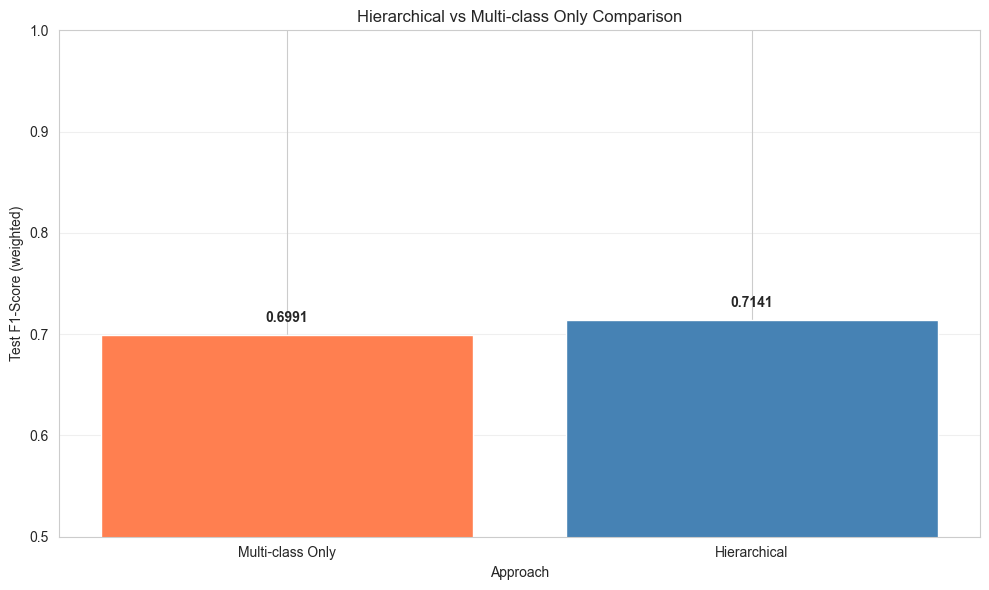

In [9]:
# Compare approaches
final_comparison = pd.DataFrame([
    {
        'Approach': 'Multi-class Only',
        'Model': best_multi_name,
        'Test F1': best_multi_f1,
        'Test Accuracy': multiclass_results_df.iloc[0]['Test Accuracy']
    },
    {
        'Approach': 'Hierarchical',
        'Model': f"{best_binary_name} + {best_multi_name}",
        'Test F1': hierarchical_f1,
        'Test Accuracy': hierarchical_acc
    }
])

print("\n" + "="*80)
print("FINAL COMPARISON: HIERARCHICAL VS MULTI-CLASS ONLY")
print("="*80)
print(final_comparison.to_string(index=False))

# Determine best approach
best_approach_idx = final_comparison['Test F1'].idxmax()
best_approach = final_comparison.iloc[best_approach_idx]['Approach']
best_f1 = final_comparison.iloc[best_approach_idx]['Test F1']

print(f"\n" + "="*80)
print(f"BEST APPROACH: {best_approach}")
print(f"Test F1-Score: {best_f1:.4f}")
print("="*80)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(final_comparison))
ax.bar(x_pos, final_comparison['Test F1'], color=['coral', 'steelblue'])
ax.set_xlabel('Approach')
ax.set_ylabel('Test F1-Score (weighted)')
ax.set_title('Hierarchical vs Multi-class Only Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(final_comparison['Approach'])
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(final_comparison['Test F1']):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Confusion Matrix for Best Approach

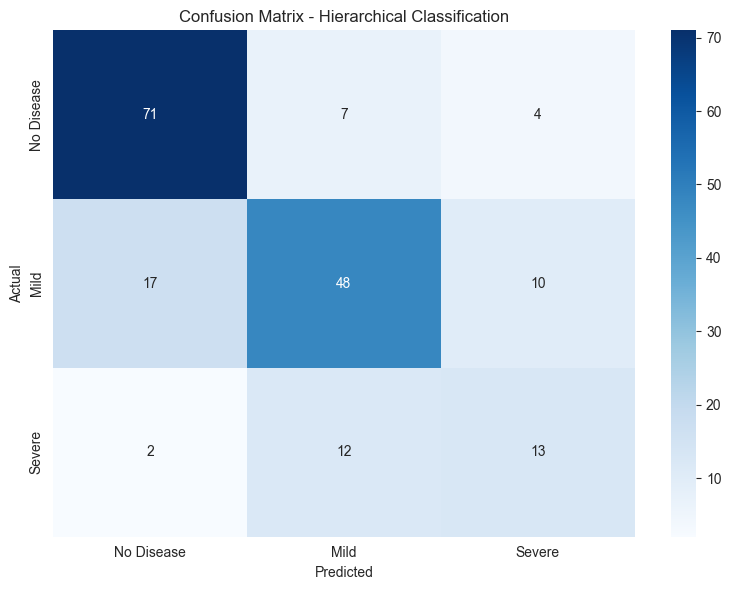


Detailed Classification Report - Hierarchical Classification:
              precision    recall  f1-score   support

  No Disease       0.79      0.87      0.83        82
        Mild       0.72      0.64      0.68        75
      Severe       0.48      0.48      0.48        27

    accuracy                           0.72       184
   macro avg       0.66      0.66      0.66       184
weighted avg       0.71      0.72      0.71       184



In [10]:
# Generate predictions based on best approach
if best_approach == 'Hierarchical':
    y_pred_final = y_pred_hierarchical
    title = 'Hierarchical Classification'
else:
    if 'Ordinal' in best_multi_name:
        y_pred_final_raw = best_multi_model.predict(X_test_multi)
        y_pred_final = np.clip(np.round(np.nan_to_num(y_pred_final_raw, nan=1.0)), 0, 2).astype(int)
    else:
        y_pred_final = best_multi_model.predict(X_test_multi)
    title = f'{best_multi_name}'

# Plot confusion matrix
cm = confusion_matrix(y_test_multi, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Mild', 'Severe'],
            yticklabels=['No Disease', 'Mild', 'Severe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {title}')
plt.tight_layout()
plt.show()

print(f"\nDetailed Classification Report - {title}:")
print(classification_report(y_test_multi, y_pred_final, 
                          target_names=['No Disease', 'Mild', 'Severe']))

## 8. Feature Importance Analysis

Analyze which features are most important for our Random Forest model's predictions.

Feature Importance Rankings:
ca                  : 0.1041 (10.41%)
age                 : 0.0893 (8.93%)
cv_risk_score       : 0.0835 (8.35%)
cp                  : 0.0810 (8.10%)
thalch              : 0.0783 (7.83%)
exang               : 0.0728 (7.28%)
hr_reserve          : 0.0717 (7.17%)
oldpeak             : 0.0713 (7.13%)
chol                : 0.0573 (5.73%)
trestbps            : 0.0544 (5.44%)
age_group           : 0.0471 (4.71%)
slope               : 0.0391 (3.91%)
thal                : 0.0353 (3.53%)
bp_category         : 0.0290 (2.90%)
restecg             : 0.0289 (2.89%)
sex                 : 0.0192 (1.92%)
fbs                 : 0.0192 (1.92%)
chol_category       : 0.0184 (1.84%)


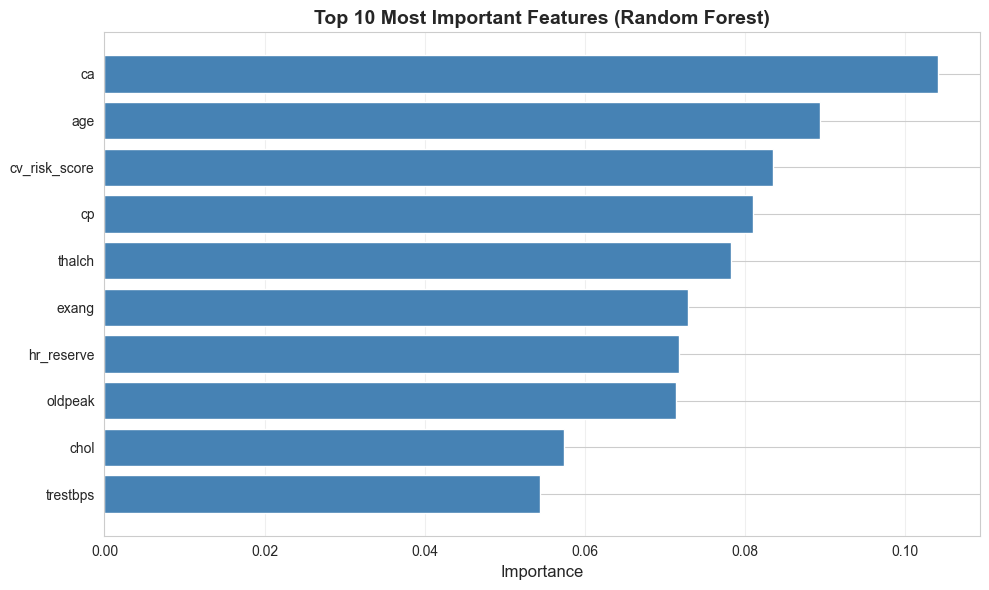


Feature Importance by Category:
Clinical Tests      : 0.2499 (24.99%)
Vital Signs         : 0.1900 (19.00%)
Demographics        : 0.1085 (10.85%)
Symptoms            : 0.2019 (20.19%)
Engineered          : 0.2497 (24.97%)

Top 5 Most Important Features:
12. ca                  : 10.41%
1. age                 : 8.93%
18. cv_risk_score       : 8.35%
3. cp                  : 8.10%
8. thalch              : 7.83%


In [11]:
# Extract feature importance from the best Random Forest model
# The hierarchical classifier uses best_multi_model for severity prediction
# Get the actual Random Forest model
if 'Random Forest' in best_multi_name:
    rf_model = best_multi_model  # This is the Random Forest
else:
    # If best model isn't Random Forest, we still want to analyze Random Forest
    # since it's interpretable. Train a quick Random Forest if needed.
    from sklearn.ensemble import RandomForestClassifier
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    
    # Apply SMOTE to training data
    smote = BorderlineSMOTE(random_state=42, k_neighbors=3)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_multi, y_train_multi)
    
    # Train Random Forest for feature importance analysis
    rf_model.fit(X_train_balanced, y_train_balanced)
    print("Note: Trained Random Forest for feature importance analysis")
    print()

# Get feature importances
feature_names = X_train_multi.columns
importances = rf_model.feature_importances_

# Create DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Feature Importance Rankings:")
print("="*60)
for idx, row in feature_importance_df.iterrows():
    print(f"{row['Feature']:20s}: {row['Importance']:.4f} ({row['Importance']*100:.2f}%)")

# Visualize top 10 features
plt.figure(figsize=(10, 6))
top_n = 10
top_features = feature_importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Group by feature categories
print("\n" + "="*60)
print("Feature Importance by Category:")
print("="*60)

# Categorize features
categories = {
    'Clinical Tests': ['ca', 'thal', 'oldpeak', 'slope'],
    'Vital Signs': ['trestbps', 'chol', 'thalch'],
    'Demographics': ['age', 'sex'],
    'Symptoms': ['cp', 'exang', 'fbs', 'restecg'],
    'Engineered': ['age_group', 'bp_category', 'chol_category', 'hr_reserve', 'cv_risk_score']
}

for category, features in categories.items():
    category_importance = feature_importance_df[
        feature_importance_df['Feature'].isin(features)
    ]['Importance'].sum()
    print(f"{category:20s}: {category_importance:.4f} ({category_importance*100:.2f}%)")

print("\n" + "="*60)
print("Top 5 Most Important Features:")
print("="*60)
for idx, row in feature_importance_df.head(5).iterrows():
    print(f"{idx+1}. {row['Feature']:20s}: {row['Importance']*100:.2f}%")

## 9. Save Model

In [12]:
# Create models directory
import os
os.makedirs('../models', exist_ok=True)

# Determine which models to save based on best approach
if best_approach == 'Hierarchical':
    # Save both binary and multi-class models
    with open('../models/best_binary_model.pkl', 'wb') as f:
        pickle.dump(best_binary_model, f)
    print("Saved: best_binary_model.pkl")
    
    with open('../models/best_multiclass_model.pkl', 'wb') as f:
        pickle.dump(best_multi_model, f)
    print("Saved: best_multiclass_model.pkl")
    
    with open('../models/hierarchical_classifier.pkl', 'wb') as f:
        pickle.dump(hierarchical_clf, f)
    print("Saved: hierarchical_classifier.pkl")
    
    final_model_name = 'Hierarchical'
else:
    # Save only multi-class model
    with open('../models/best_multiclass_model.pkl', 'wb') as f:
        pickle.dump(best_multi_model, f)
    print("Saved: best_multiclass_model.pkl")
    
    final_model_name = best_multi_name

# Save model metadata
metadata = {
    'best_approach': best_approach,
    'final_model_name': final_model_name,
    'best_f1_score': float(best_f1),
    'binary_model_name': best_binary_name if best_approach == 'Hierarchical' else None,
    'multiclass_model_name': best_multi_name,
    'feature_names': X_train_multi.columns.tolist(),
    'class_names': {0: 'No Disease', 1: 'Mild Disease', 2: 'Severe Disease'},
    'random_state': RANDOM_STATE,
    'smote_method': 'BorderlineSMOTE (borderline-1)',
    'severity_grouping': 'Original 1-2 → 1 (Mild), 3-4 → 2 (Severe)'
}

with open('../models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("Saved: model_metadata.pkl")

print(f"\nAll models saved to: ../models/")

Saved: best_binary_model.pkl
Saved: best_multiclass_model.pkl
Saved: hierarchical_classifier.pkl
Saved: model_metadata.pkl

All models saved to: ../models/


## 10. Training Summary

Summary of all model training results and final performance.

In [13]:
print("\n" + "="*80)
print("HEART DISEASE PREDICTION - TRAINING SUMMARY")
print("="*80)

print(f"\n1. BINARY CLASSIFICATION (Disease Detection)")
print(f"   Best Model: {best_binary_name}")
print(f"   Test F1-Score: {best_binary_f1:.4f}")

print(f"\n2. MULTI-CLASS CLASSIFICATION (Severity Assessment)")
print(f"   Best Model: {best_multi_name}")
print(f"   Test F1-Score: {best_multi_f1:.4f}")
print(f"   Models Tested: 7 (RF, XGBoost, XGB Ordinal, GB, SVM, LogReg, KNN)")
print(f"   Severity Grouping: 1-2 → Mild, 3-4 → Severe")

if best_approach == 'Hierarchical':
    print(f"\n3. HIERARCHICAL CLASSIFICATION")
    print(f"   Stage 1 (Binary): {best_binary_name}")
    print(f"   Stage 2 (Multi-class): {best_multi_name}")
    print(f"   Test F1-Score: {hierarchical_f1:.4f}")

print(f"\n4. FINAL APPROACH SELECTED")
print(f"   Approach: {best_approach}")
print(f"   Model: {final_model_name}")
print(f"   Test F1-Score: {best_f1:.4f}")
print(f"   Test Accuracy: {final_comparison.iloc[best_approach_idx]['Test Accuracy']:.4f}")

print(f"\n5. TECHNIQUES USED")
print(f"   - Severity Grouping: 5 classes → 3 classes for better balance")
print(f"   - Class Imbalance: BorderlineSMOTE (borderline-1)")
print(f"   - Hyperparameter Tuning: RandomizedSearchCV with 5-fold CV")
print(f"   - XGBoost Ordinal: Tested for ordinal severity prediction")
print(f"   - Evaluation: F1-score (weighted) as primary metric")

print(f"\n6. MODELS SAVED")
if best_approach == 'Hierarchical':
    print(f"   - best_binary_model.pkl")
    print(f"   - best_multiclass_model.pkl")
    print(f"   - hierarchical_classifier.pkl")
else:
    print(f"   - best_multiclass_model.pkl")
print(f"   - smote_multiclass.pkl")
print(f"   - model_metadata.pkl")

print(f"\n{'='*80}")
print("Training complete! Models ready for deployment.")
print("="*80)


HEART DISEASE PREDICTION - TRAINING SUMMARY

1. BINARY CLASSIFICATION (Disease Detection)
   Best Model: SVM
   Test F1-Score: 0.8530

2. MULTI-CLASS CLASSIFICATION (Severity Assessment)
   Best Model: Random Forest
   Test F1-Score: 0.6991
   Models Tested: 7 (RF, XGBoost, XGB Ordinal, GB, SVM, LogReg, KNN)
   Severity Grouping: 1-2 → Mild, 3-4 → Severe

3. HIERARCHICAL CLASSIFICATION
   Stage 1 (Binary): SVM
   Stage 2 (Multi-class): Random Forest
   Test F1-Score: 0.7141

4. FINAL APPROACH SELECTED
   Approach: Hierarchical
   Model: Hierarchical
   Test F1-Score: 0.7141
   Test Accuracy: 0.7174

5. TECHNIQUES USED
   - Severity Grouping: 5 classes → 3 classes for better balance
   - Class Imbalance: BorderlineSMOTE (borderline-1)
   - Hyperparameter Tuning: RandomizedSearchCV with 5-fold CV
   - XGBoost Ordinal: Tested for ordinal severity prediction
   - Evaluation: F1-score (weighted) as primary metric

6. MODELS SAVED
   - best_binary_model.pkl
   - best_multiclass_model.pkl
  